In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import random
#import dsets
#import futils

In [4]:
import glob
import os
import csv


PATH = "../raw_ct_data/"

def get_dataset_infos():
    # --- make a filename list of full CT data (888 person) --- #
    filenames = glob.glob( PATH+"subset*/*.mhd" )
    filenames_set = {os.path.split(name)[-1][:-4] for name in filenames}  # 888 full CT data
    
    # --- make a diameter dictionary from annotation.csv file --- #
    # value of the dict is a list, and if suid is a duplicate, it will be added to the list.
    anno_dic = {}
    with open( PATH+"annotations.csv", "r" ) as f:
        for row in list(csv.reader(f))[1:]:
            suid     = row[0]
            center   = tuple([float(x) for x in row[1:4]])
            diameter = float(row[4])
            anno_dic.setdefault(suid,[]).append( (center, diameter), )

    ds_infos = []
    with open( PATH+"candidates.csv", "r" ) as f:
        for row in list(csv.reader(f))[1:]:   # 550,000 candidates
            suid     = row[0]
            nodule   = [1,0] if row[4] == "0" else [0,1]
            center   = [float(x) for x in row[1:4]]
            diameter = 0.0
            
            if nodule == [0,1]:
                for ac,ad in anno_dic.get(suid,[]):
                    diffs = [ abs(c-a) <= ad/4 for c,a in zip(center,ac) ]
                    if all(diffs): 
                        diameter = ad
                        break
                        
            if nodule == [0,1] and diameter == 0.0:
                continue
            else:
                ds_infos.append( [diameter,nodule,suid,center] )

    ds_infos.sort(reverse=True)  # diameter is only for this process
    ds_infos = [ [s1,s2,s3,s0] for s0,s1,s2,s3 in ds_infos ]
    return ds_infos


def train_test_splitting(lis,size=None,offset=5,stride=5):
    n = len(lis)
    if size is None: size = ( n - offset ) // stride + 1
        
    end = offset + size*stride
    print(f"coverage: {int(end/n*100)} %")
    
    if end > n: end = n
        
    tra = list(lis)
    tes = tra[offset:end:stride]
    del tra[offset:end:stride]
    return tra,tes




# --- full informations ---
infos = get_dataset_infos()

# --- separate the infos into positive 1 and negative 0 ---
ful1,ful0 = infos[:1028],infos[1028:] 
#print(f"{len(infos)}")
#for i,info in enumerate(infos[:20]):
#    print(i,info)


# --- for positive samples ---
tra1,tes1 = train_test_splitting(ful1,size=200,offset=5,stride=5)


# --- for negative samples ---
#    limit the number of data
ful0_cut = random.sample(ful0,20200)
tra0,tes0 = train_test_splitting(ful0_cut,size=200,offset=0,stride=101)   # 20200 / 200 = 101

print()
print(f"ful1 = tra1 : tes1")
print(f"{len(ful1)} = {len(tra1)} : {len(tes1)}")
print()
print(f"ful0_cut (/ful0) = tra0 : tes0")
print(f"{len(ful0_cut)} (/{len(ful0)}) = {len(tra0)} : {len(tes0)}")




#print()
#print("tes1:")
#for i,tes in enumerate(tes1):
#    print(i,tes)

coverage: 97 %
coverage: 100 %

ful1 = tra1 : tes1
1028 = 828 : 200

ful0_cut (/ful0) = tra0 : tes0
20200 (/549714) = 20000 : 200


In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
import os
import csv
import SimpleITK as sitk

from datetime import datetime
import h5py


class CT:
    def __init__(self,suid):
        mhd_path = glob.glob( PATH+f"subset*/{suid}.mhd")[0]
        mhd = sitk.ReadImage(mhd_path)    
        self.origin    = np.array(mhd.GetOrigin())
        self.spacing   = np.array(mhd.GetSpacing())
        self.direction = np.array(mhd.GetDirection()).reshape(3, 3)
        
        self.arr = np.array(sitk.GetArrayFromImage(mhd), dtype=np.float32)
        self.arr.clip(-1000, 1000, self.arr)
        self.shape = self.arr.shape


    def get_center(self,center):
        irc = ((center - self.origin) @ np.linalg.inv(self.direction)) / self.spacing
        return [ round(irc[2]), round(irc[1]), round(irc[0]) ]

    def get_slices(self,center):
        width  = (32,48,48)
        center_irc = self.get_center(center)
        
        slices = []
        for c,w,s in zip(center_irc, width, self.shape):
            sta_idx = round(c - w / 2)
            end_idx = sta_idx + w
            if sta_idx < 0:
                sta_idx = 0
                end_idx = w
            if end_idx > s:
                end_idx = s
                sta_idx = s - w
            slices.append(slice(sta_idx, end_idx))
        return slices
        
    def get_chunked_ct(self,center):
        slices = self.get_slices(center)
        return self.arr[tuple(slices)]

    def get_sliced_ct(self,center):
        slices = self.get_slices(center)
        return self.arr[slices[0],:,:]


    def imshow2(self, sliced_ct, chunked_ct):
        slices = self.get_slices(center)
        for i,(img1,img2) in enumerate(zip(sliced_ct,chunked_ct)): 
            print(i)
            plt.subplot(1, 2, 1)
            plt.imshow(img1)
            rect = patches.Rectangle((slices[2].start,slices[1].start),48,48, linewidth=1,edgecolor='white',facecolor='none')
            plt.gca().add_patch(rect)   
            plt.title(f"{i+slices[0].start}")
            
            plt.subplot(1, 2, 2)
            plt.imshow(img2)
            plt.title(f"Nodule: {nodule}")
            plt.show()



info = tra0
label = 0
file_name = "tra_neg"


path = f"/Users/fujii/Desktop/dataset/"
t0 = datetime.now()

with h5py.File(path+f"{file_name}.h5", "w") as f:
    for i,(nodule,suid,center,size) in enumerate(info):
        if i % bunch_size == 0:
            print(i,size)
        ct = CT(suid)
        ci,cr,cc = ct.get_center(center)
        
        #img0 = ct.arr[ci-1, cr-24:cr+24, cc-24:cc+24]
        img1 = ct.arr[ci  , cr-24:cr+24, cc-24:cc+24]
        #img2 = ct.arr[ci+1, cr-24:cr+24, cc-24:cc+24]
         
        f.create_dataset(f"x{i:06}",data=img1)
        f.create_dataset(f"t{i:06}",data=label)

        #f.create_dataset(f"x{i:06}_0",data=img0)
        #f.create_dataset(f"t{i:06}_0",data=label)        
        #f.create_dataset(f"x{i:06}_1",data=img1)
        #f.create_dataset(f"t{i:06}_1",data=label)        
        #f.create_dataset(f"x{i:06}_2",data=img2)
        #f.create_dataset(f"t{i:06}_2",data=label)


print(datetime.now()-t0)


#np.savez("/Users/fujii/Desktop/npz_test", id1=img2)






#ct.imshow2([ct.arr[ci]],[img2])
#ct.imshow2([ct.arr[ci]],[npzc['id1']])


#for img in imgs:
#    #plt.figure(figsize=(1,1))
#    plt.imshow(img)
 #   plt.show()
    




0 0.0
10 0.0
20 0.0
30 0.0
40 0.0
50 0.0
60 0.0
70 0.0
80 0.0
90 0.0
100 0.0
110 0.0
120 0.0
130 0.0
140 0.0
150 0.0
160 0.0
170 0.0
180 0.0
190 0.0
200 0.0
210 0.0
220 0.0
230 0.0
240 0.0
250 0.0
260 0.0
270 0.0
280 0.0
290 0.0
300 0.0
310 0.0
320 0.0
330 0.0
340 0.0
350 0.0
360 0.0
370 0.0
380 0.0
390 0.0
400 0.0
410 0.0
420 0.0
430 0.0
440 0.0
450 0.0
460 0.0
470 0.0
480 0.0
490 0.0
500 0.0
510 0.0
520 0.0
530 0.0
540 0.0
550 0.0
560 0.0
570 0.0
580 0.0
590 0.0
600 0.0
610 0.0
620 0.0
630 0.0
640 0.0
650 0.0
660 0.0
670 0.0
680 0.0
690 0.0
700 0.0
710 0.0
720 0.0
730 0.0
740 0.0
750 0.0
760 0.0
770 0.0
780 0.0
790 0.0
800 0.0
810 0.0
820 0.0
830 0.0
840 0.0
850 0.0
860 0.0
870 0.0
880 0.0
890 0.0
900 0.0
910 0.0
920 0.0
930 0.0
940 0.0
950 0.0
960 0.0
970 0.0
980 0.0
990 0.0
1000 0.0
1010 0.0
1020 0.0
1030 0.0
1040 0.0
1050 0.0
1060 0.0
1070 0.0
1080 0.0
1090 0.0
1100 0.0
1110 0.0
1120 0.0
1130 0.0
1140 0.0
1150 0.0
1160 0.0
1170 0.0
1180 0.0
1190 0.0
1200 0.0
1210 0.0
1220 0.0
1230

20000
(48, 0)
(48, 0)
(48, 43)
(41, 48)
(40, 48)
(39, 48)
(41, 48)
(40, 48)
(41, 48)
(43, 48)
(48, 0)
0


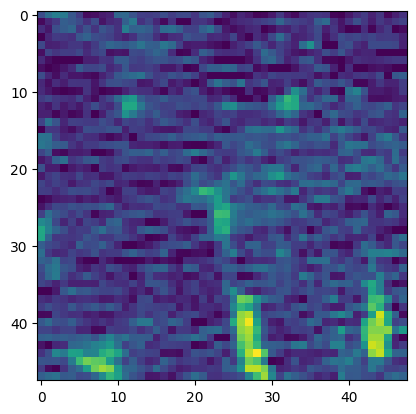

In [87]:

with h5py.File(path+f"{file_name}.h5", "r") as f:
    n = len(f.keys())//2
    print(n)
    for i in range(n):
        t = np.array(f[f"t{i:06}"])
        x = np.array(f[f"x{i:06}"])
        if x.shape != (48,48):
            print(x.shape)
        

print(t)
plt.imshow(x)
plt.show()





In [93]:






path = f"/Users/fujii/Desktop/dataset/"

t0 = datetime.now()
with h5py.File(path+f"tra_neg_new.h5", "w") as fo:
    with h5py.File(path+f"tra_neg.h5", "r") as fi:
        n = len(fi.keys())//2
        print(n)
        cnt = 0
        for i in range(n):
            if i % 100 == 0: print(i)
            x = np.array(fi[f"x{i:06}"])
            t = np.array(fi[f"t{i:06}"])
            if x.shape == (48,48):
                fo.create_dataset(f"x{cnt:06}",data=x)
                fo.create_dataset(f"t{cnt:06}",data=t)
                cnt += 1
            else:
                print(x.shape)
                
print(datetime.now()-t0)



with h5py.File(path+f"tra_neg_new.h5", "r") as f:
    n = len(f.keys())//2
    print(n)
    for i in range(n):
        t = np.array(f[f"t{i:06}"])
        x = np.array(f[f"x{i:06}"])
        if x.shape != (48,48):
            print(i,x.shape)
            idx_lis.append(i)
            





20000
0
100
200
300
400
500
600
700
800
900
1000
1100
(48, 0)
1200
(48, 0)
1300
1400
1500
1600
1700
1800
(48, 43)
1900
2000
2100
2200
2300
2400
2500
2600
2700
(41, 48)
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
(40, 48)
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
(39, 48)
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
(41, 48)
8200
(40, 48)
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
(41, 48)
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
(43, 48)
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
1690

In [95]:
with h5py.File(path+f"tra_neg_new.h5", "r") as f:
    n = len(f.keys())//2
    print(n)

19989


In [106]:


def rotation(image,angle,flip=False):
    m,n = image.shape
    center = np.array( [ (m-1)/2, (n-1)/2 ] )
    rot_mat = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                       [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    if flip:
        rot_mat = np.array([[1, 0],[0, -1]]) @ rot_mat
    rot_image = np.zeros_like(image)
    for i in range(m):
        for j in range(n):
            cij = [i,j] - center
            rij =  cij @ rot_mat + center
            rot_image[i,j] = image[round(rij[0]),round(rij[1])]
    return rot_image




paras = [(0,False),(90,False),(180,False),(270,False),(0,True),(90,True),(180,True),(270,True)]

path = f"/Users/fujii/Desktop/dataset/"


t0 = datetime.now()
with h5py.File(path+f"tes_pos_att.h5", "w") as fo:
    with h5py.File(path+f"tes_pos.h5", "r") as fi:
        n = len(fi.keys())//2
        print(n)
        cnt = 0
        for i in range(n):
            if i % 10 == 0: print(i)
            for j in range(3):
                x = np.array(fi[f"x{i:06}_{j}"])
                t = np.array(fi[f"t{i:06}_{j}"])
                if x.shape != (48,48): print(x.shape)
                for angle,flip in paras:
                    x_rot = rotation(x,angle,flip)
                    ds = fo.create_dataset(f"{cnt:06}",data=x_rot)
                    ds.attrs["t"] = 1
                    cnt += 1
                
print(datetime.now()-t0)

            



2484
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820


KeyError: "Unable to open object (object 'x000828_0' doesn't exist)"

200
0


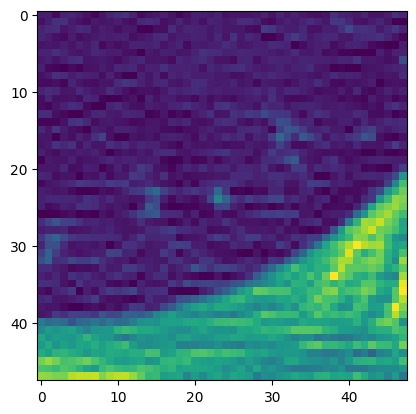

0


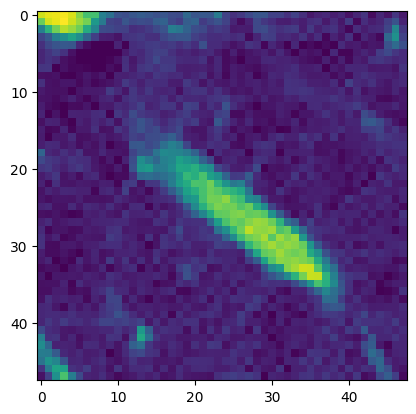

0


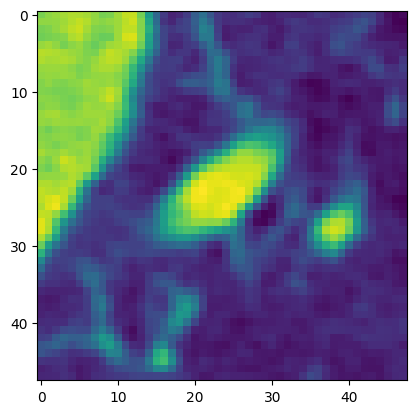

0


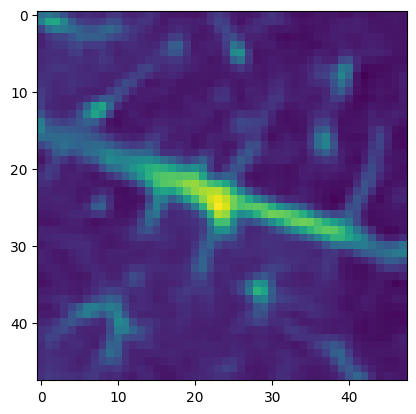

0


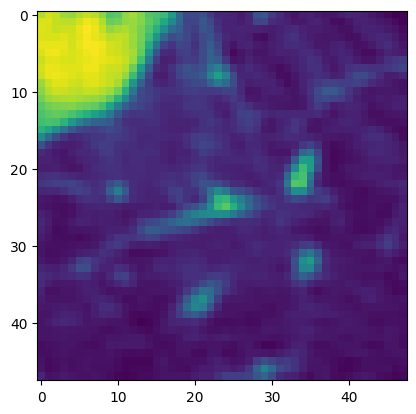

0


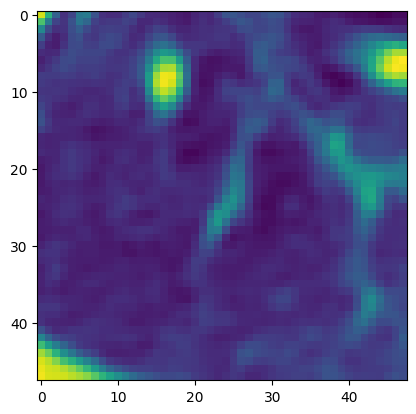

0


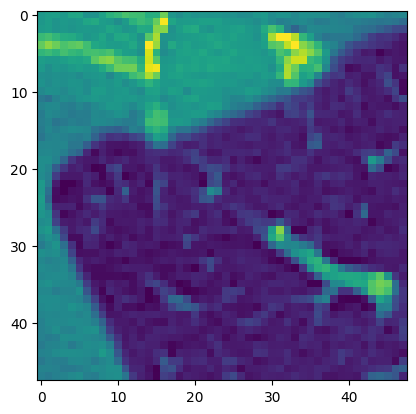

0


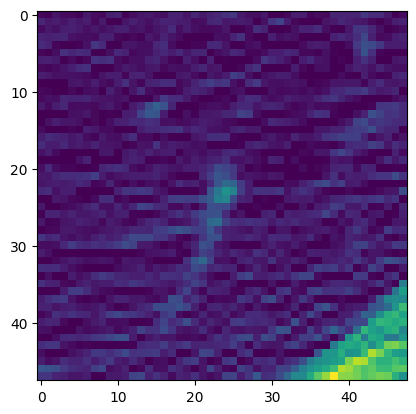

0


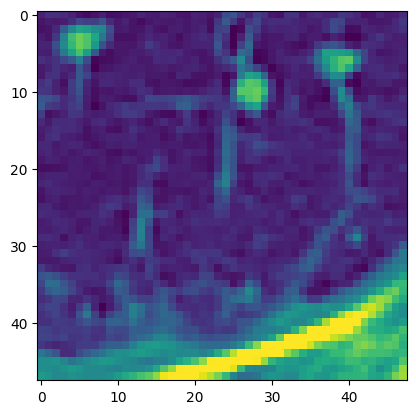

0


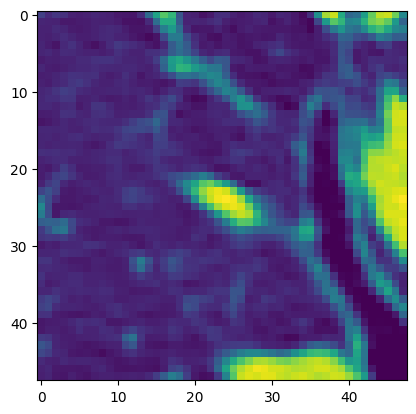

0


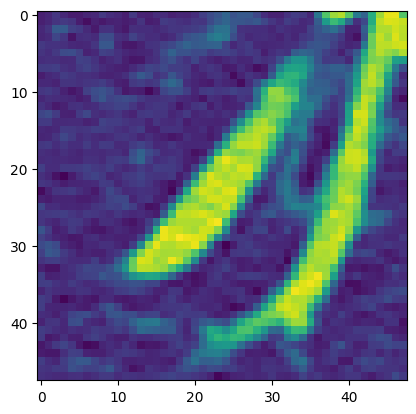

0


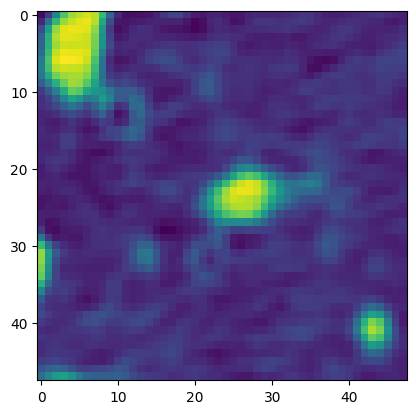

0


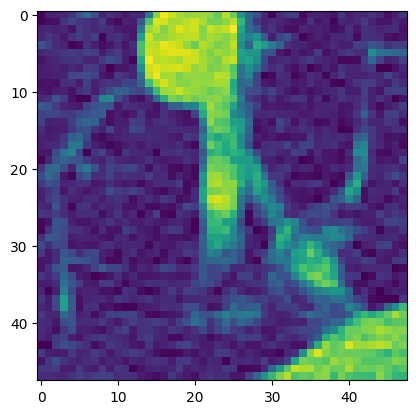

0


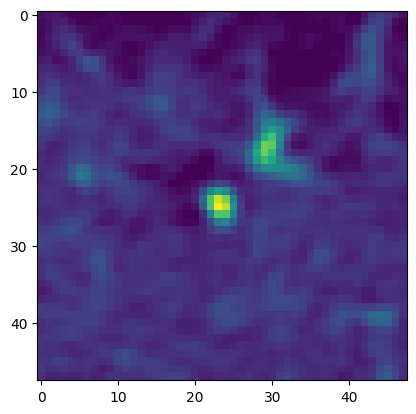

0


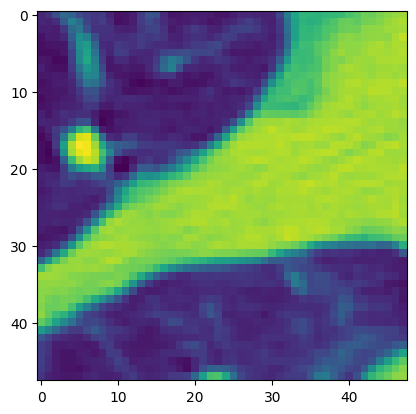

0


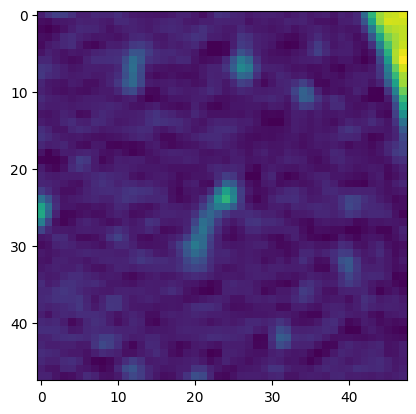

0


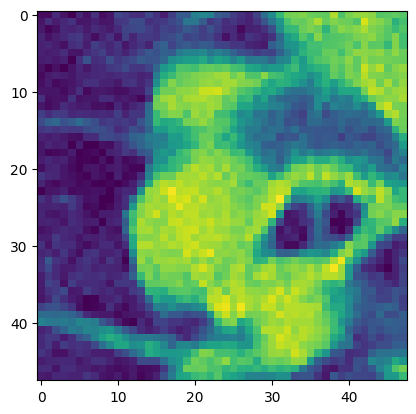

0


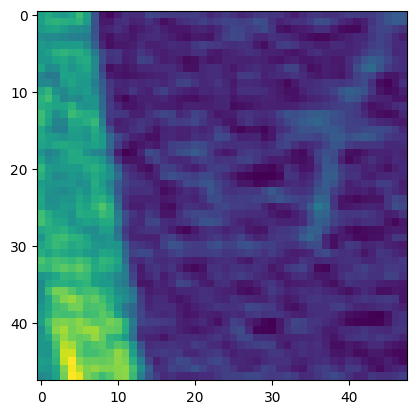

0


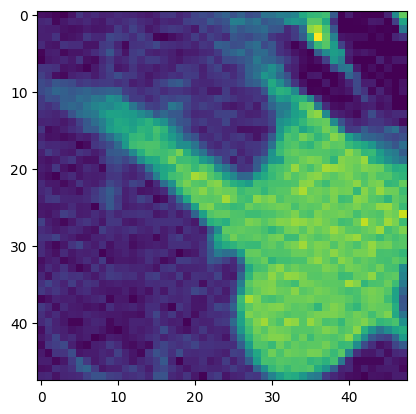

0


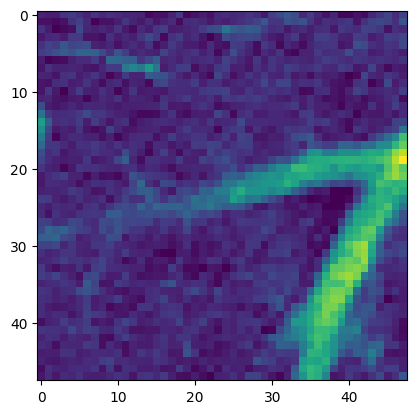

0


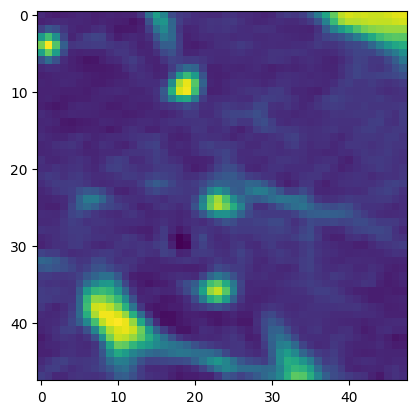

0


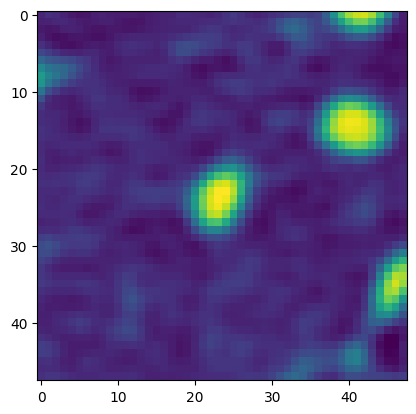

0


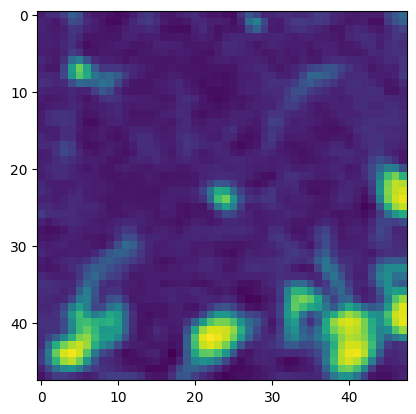

0


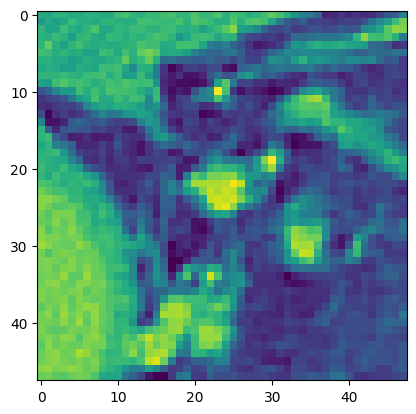

0


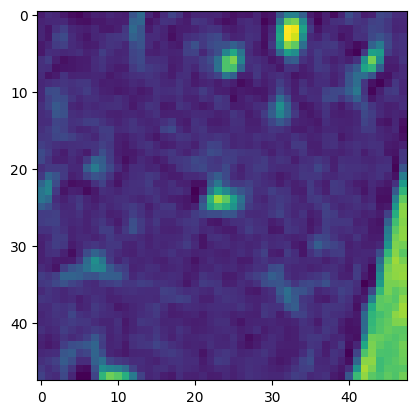

0


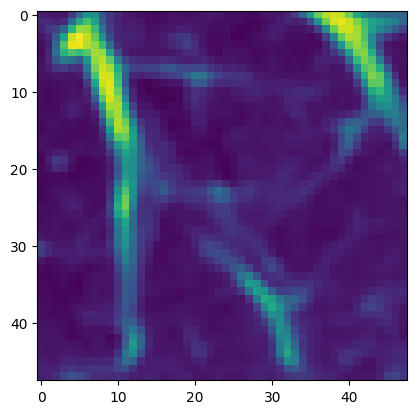

0


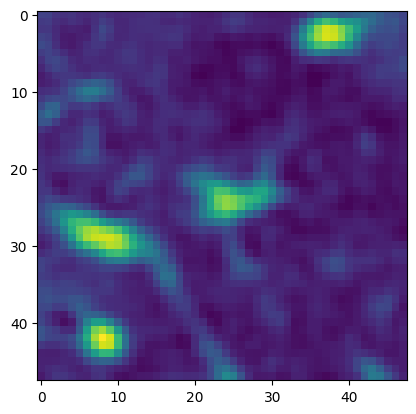

0


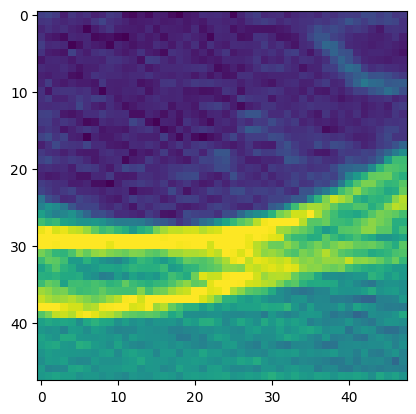

0


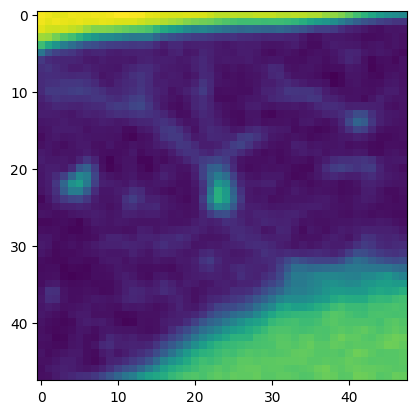

0


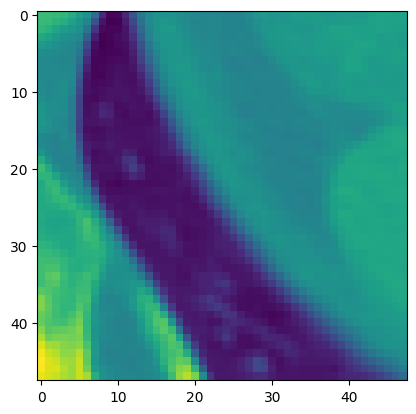

0


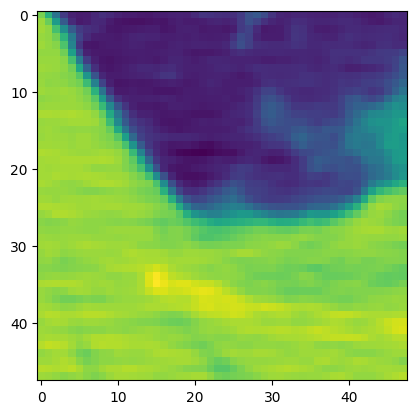

0


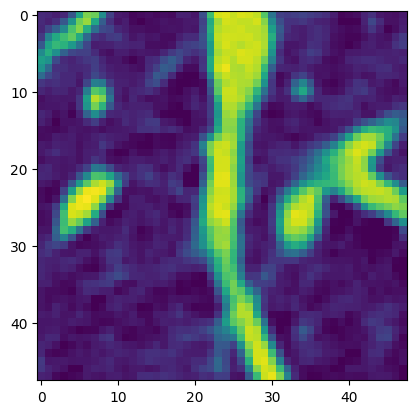

0


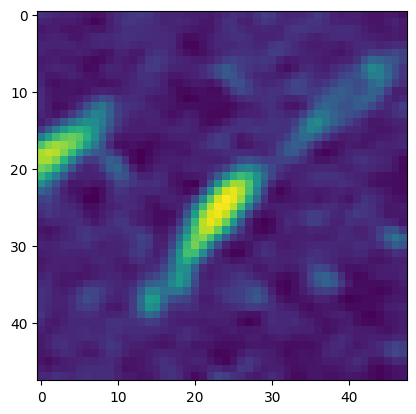

0


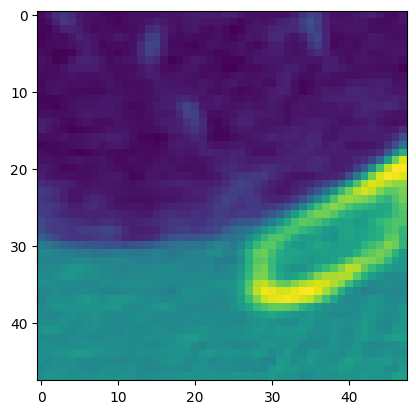

0


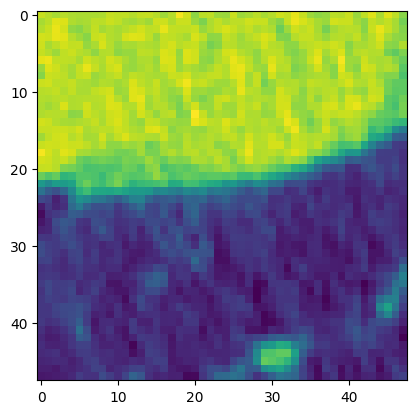

0


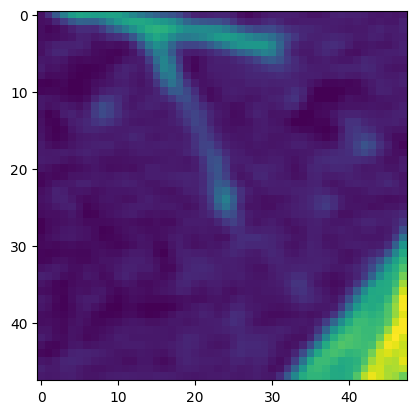

0


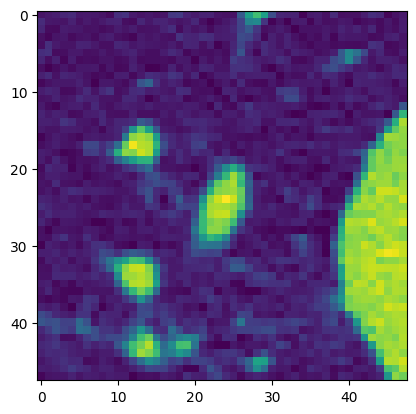

0


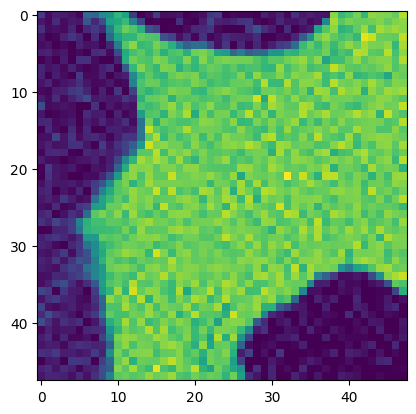

0


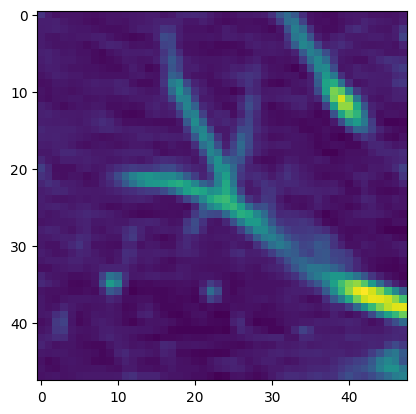

0


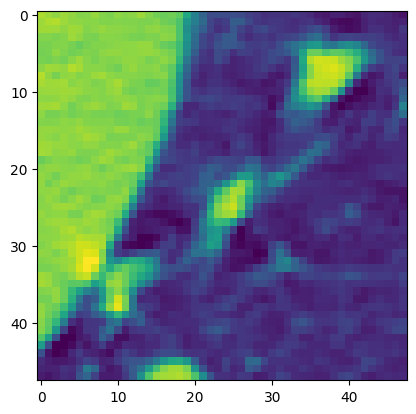

0


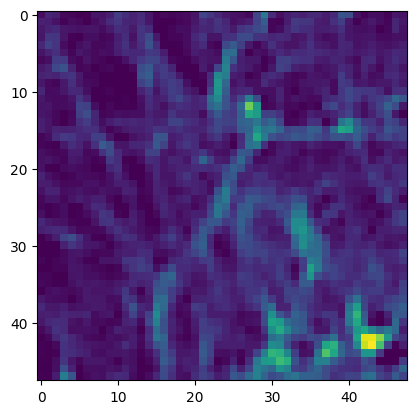

0


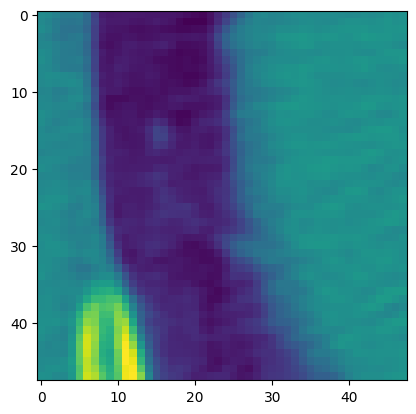

0


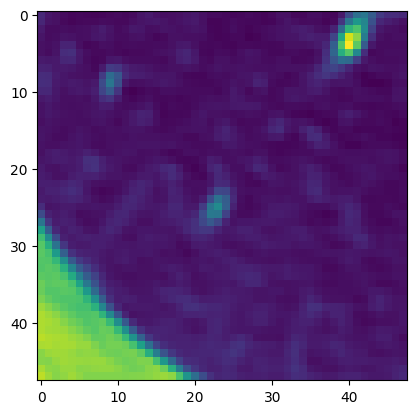

0


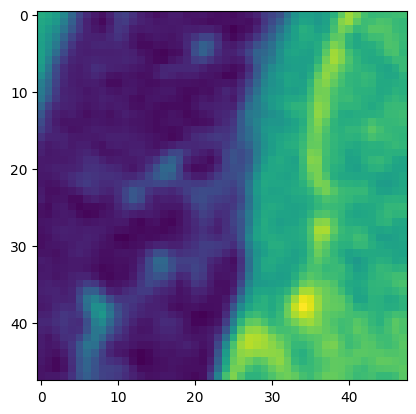

0


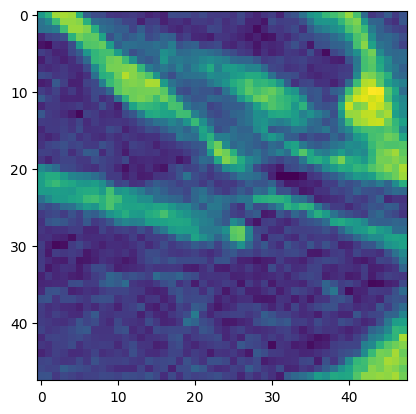

0


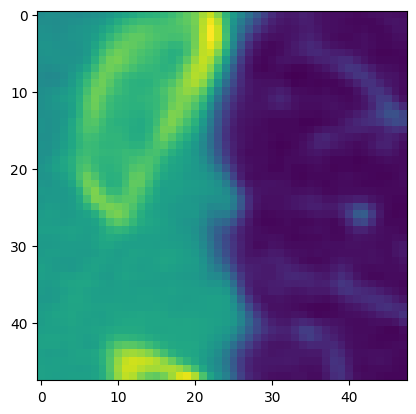

0


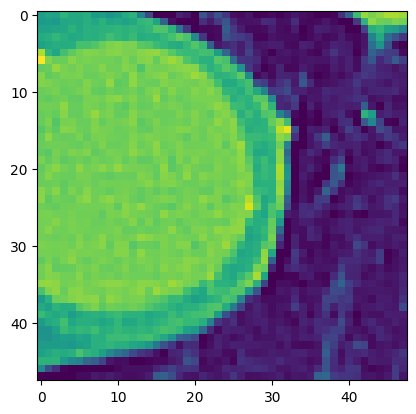

0


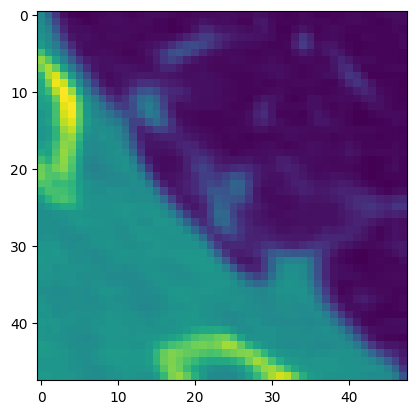

In [113]:
with h5py.File(path+f"tes_neg_att.h5", "r") as fi:
    print(len(fi.keys()))
    idx_lis = range(48)
    for idx in idx_lis:
        sidx = f"{idx:06}"
        t = fi[sidx].attrs["t"]
        x = np.array(fi[sidx])
        print(t)
        plt.imshow(x)
        plt.show()


In [112]:
path = f"/Users/fujii/Desktop/dataset/"

t0 = datetime.now()
with h5py.File(path+f"tes_neg_att.h5", "w") as fo:
    with h5py.File(path+f"tes_neg.h5", "r") as fi:
        n = len(fi.keys())//2
        print(n)
        cnt = 0
        for i in range(n):
            if i % 10 == 0: print(i)
            x = np.array(fi[f"x{i:06}"])
            if x.shape != (48,48): print(x.shape)
            ds = fo.create_dataset(f"{cnt:06}",data=x)
            ds.attrs["t"] = 0
            cnt += 1

print(datetime.now()-t0)

            

200
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0:00:00.061453
